# **1. Dataset Overview**

The dataset used in this project is sourced from the [Agricultural Pests Image Dataset](https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset/data) available on Kaggle. It contains images of pests categorized into different category. Each category is organized into a separate folder.

The categories included in the dataset are as follows:

- Ulat (Caterpillar): 434 Images
- Tawon (Wasp): 498 Images
- Siput (Snail): 500 Images
- Semut (Ants): 499 Images
- Ngengat (Moth): 497 Images
- Lintah Bulan (Slug): 391 Images
- Lebah (Bees): 500 Images
- Kumbang Penggerek (Weevil): 485 Images
- Kumbang (Beetle): 416 Images
- Capit (Earwig): 466 Images
- Cacing Tanah (Earthworms): 323 Images
- Belalang (Grasshopper): 485 Images

This dataset provides a reliable foundation for building and training deep learning models to detect and classify pests through image-based analysis.

# **2. Library Import**

This project uses the following libraries:

- `numpy`, `os`, `random`: Basic numerical operations, file system handling, and introducing randomness in data loading or augmentation.
- `matplotlib`: Used to visualize sample images and plot training metrics such as accuracy and loss.
- `tensorflow.keras.preprocessing.image`: For loading and preprocessing image datasets using ImageDataGenerator.
- `tensorflow.keras.applications`: Provides pretrained models like MobileNetV2 and Xception.
- `tensorflow.keras.models`, `tensorflow.keras.layers`: To build deep learning models using layers like Conv2D, Dense, Dropout, Flatten, and more.
- `regularizers`, `optimizers`, `callbacks`: Used to compile models and control training.
- `sklearn.metrics`: For confusion matrix and classification report.
- `time`: Tracks training duration in custom callbacks.

In [5]:
# !pip install tensorflow

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image

# **3. Data Loading**

After mounting Google Drive and specifying the dataset path, we list all available class folders to identify the categories of pests. Each folder represents a unique class such as "Siput", "Ngengat", "Tawon", or "Belalang".

To verify dataset integrity and understand the visual characteristics of each class, we randomly display a few sample images per category. This step ensures that the folder structure is correct and that the images are loaded successfully before proceeding with model training.

All images are resized to 224×224 pixels to match the input shape required by the deep learning models.

In [9]:
dataset_path = "/content/drive/MyDrive/Capstone/Hama"

class_names = os.listdir(dataset_path)
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_path, cls))]
print("Daftar Kelas:", class_names)

Daftar Kelas: ['Siput', 'Kumbang Penggerek', 'Ngengat', 'Capit', 'Cacing Tanah', 'Tawon', 'Belalang', 'Kumbang', 'Ulat', 'Lintah Bulan', 'Lebah', 'Semut']



Label: Siput


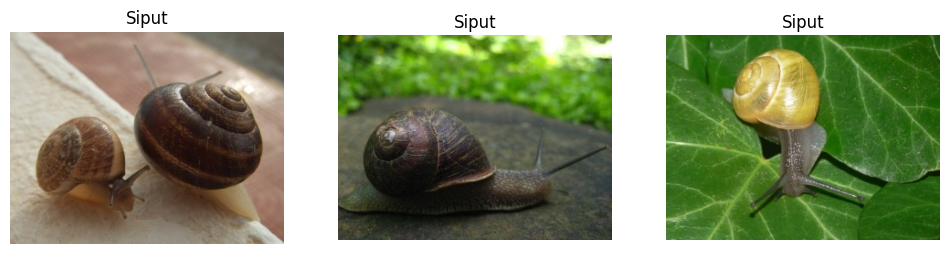


Label: Kumbang Penggerek


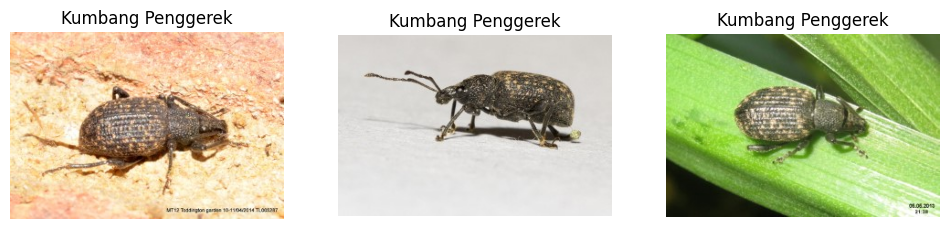


Label: Ngengat


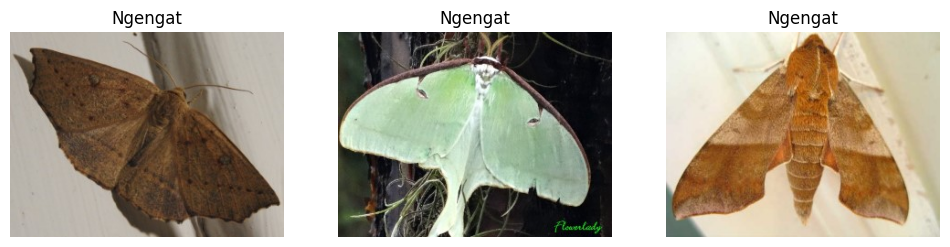


Label: Capit


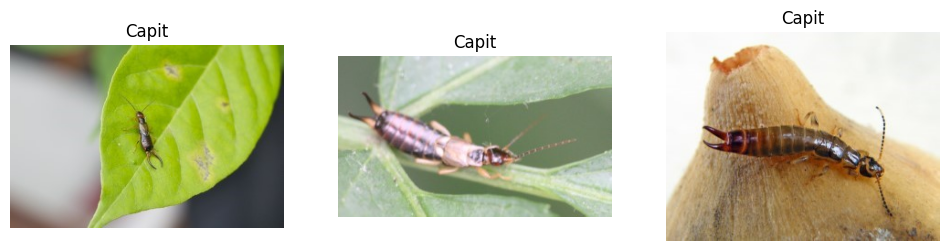


Label: Cacing Tanah


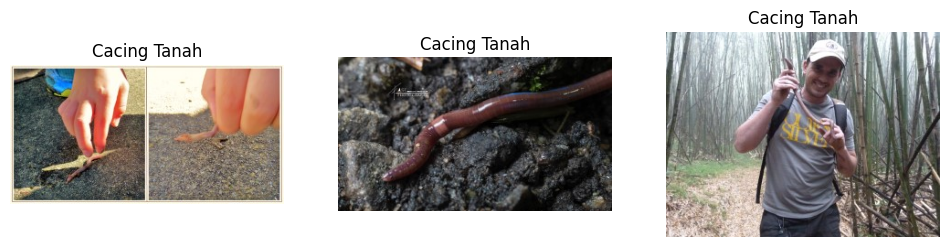


Label: Tawon


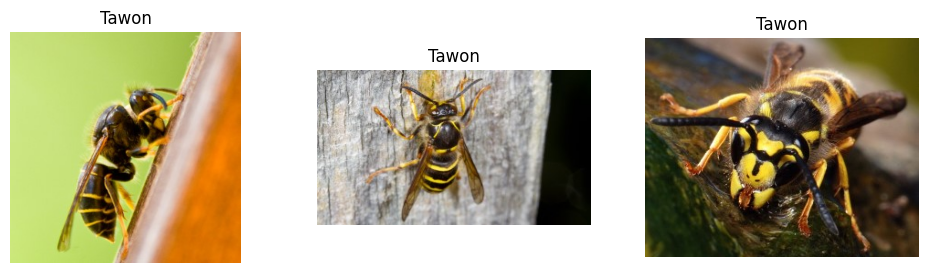


Label: Belalang


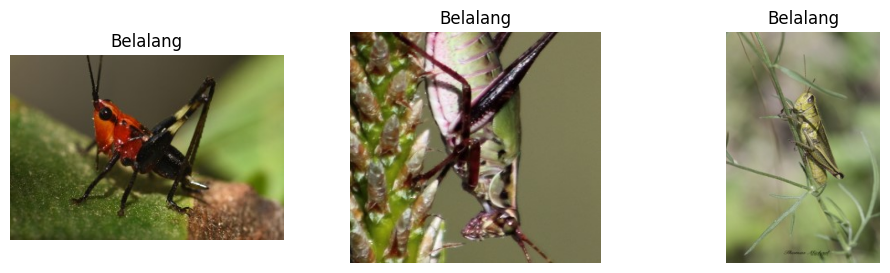


Label: Kumbang


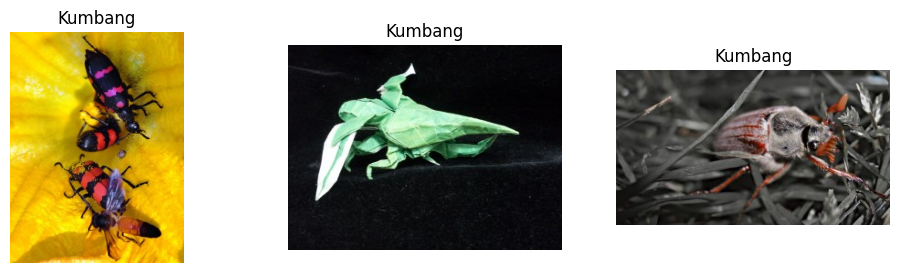


Label: Ulat


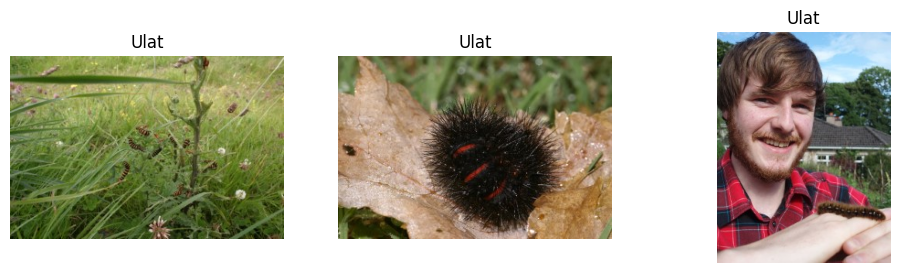


Label: Lintah Bulan


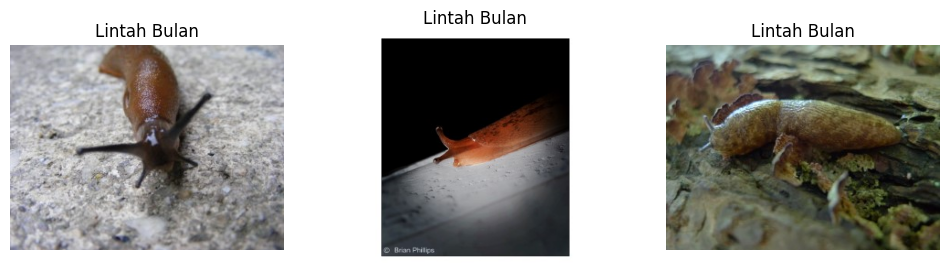


Label: Lebah


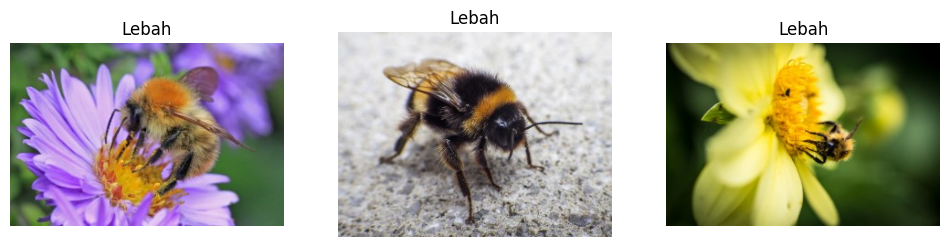


Label: Semut


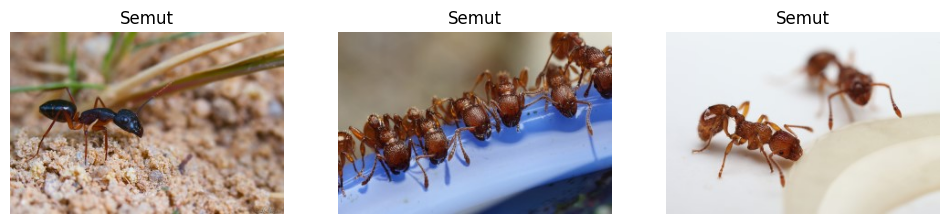

In [10]:
n_images_per_class = 3
img_size = (224, 224)

for cls in class_names:
    folder = os.path.join(dataset_path, cls)
    images = os.listdir(folder)
    selected_images = random.sample(images, min(n_images_per_class, len(images)))

    print(f"\nLabel: {cls}")
    plt.figure(figsize=(12, 3))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, n_images_per_class, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()

# **4. Data Preprocessing**

To prepare the image dataset for model training, we use `ImageDataGenerator` for normalization and augmentation. This step ensures the model can generalize better to unseen data.

- All images are rescaled by 1./255 to normalize pixel values between 0 and 1.
- Augmentation techniques such as rotation, zoom, shift, shear, and horizontal flip are applied to the training data.
- The dataset is split into training (80%) and validation (20%) using the `validation_split` argument.
- `flow_from_directory()` automatically loads images from folders and assigns labels based on folder names.
- Each image is resized to 224×224 pixels, and data is batched in size of 32 for efficient training.

A few training images are then visualized to verify that the images are loaded correctly and the class labels are mapped as expected.

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:
img_size = (224, 224)
batch_size = 32

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

Found 4399 images belonging to 12 classes.
Found 1095 images belonging to 12 classes.


In [13]:
print("Mapping label:", train_data.class_indices)

Mapping label: {'Belalang': 0, 'Cacing Tanah': 1, 'Capit': 2, 'Kumbang': 3, 'Kumbang Penggerek': 4, 'Lebah': 5, 'Lintah Bulan': 6, 'Ngengat': 7, 'Semut': 8, 'Siput': 9, 'Tawon': 10, 'Ulat': 11}


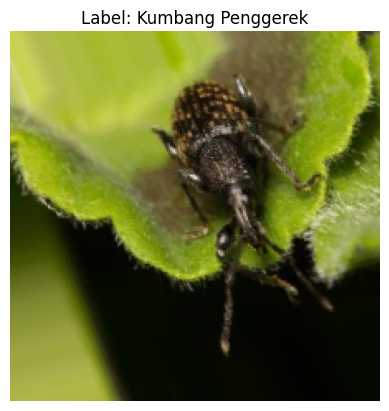

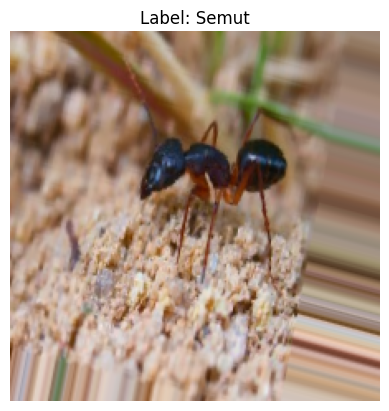

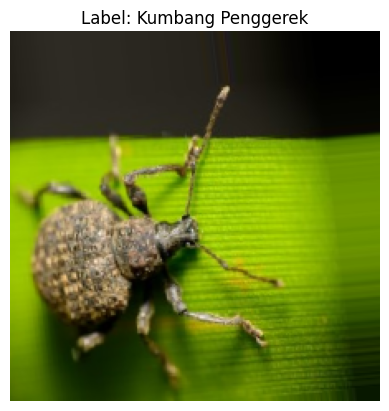

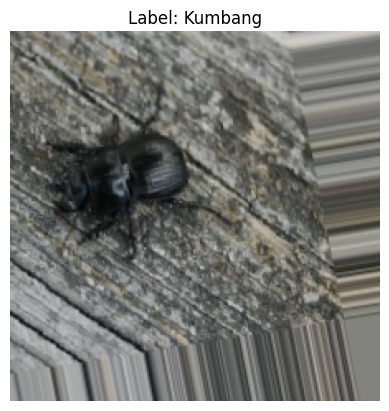

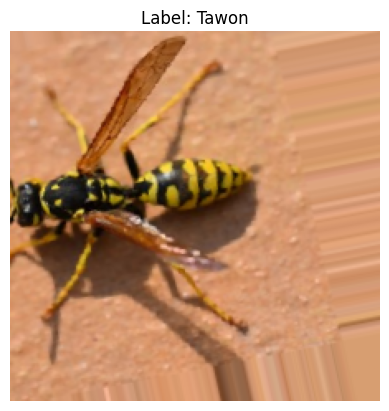

In [14]:
images, labels = next(train_data)

for i in range(5):
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_data.class_indices.keys())[label_index]
    plt.title(f"Label: {label_name}")
    plt.axis("off")
    plt.show()

# **5. Training and Evaluation**

## **a. MobileNet**

We use a pretrained MobileNetV2 as the base model with `include_top=False` to remove the original classification head. The last 20 layers are set to be trainable for fine-tuning, while earlier layers remain frozen to retain learned features from ImageNet.

A custom classification head is added on top:
- GlobalAveragePooling2D layer
- Dense layer with ReLU activation and L2 regularization
- Dropout layer to prevent overfitting
- Final Dense layer with softmax for 9 output classes

The model is compiled using:
- Optimizer: Adam (learning rate = 1e-4)
- Loss: categorical crossentropy
- Metric: accuracy

To improve training, we use:
- `EarlyStopping` to stop when validation accuracy stagnates
- `ModelCheckpoint` to save the best model based on validation accuracy
- A custom `TrainingLogger` callback to show per-epoch accuracy change and training time

The model is trained for up to 50 epochs, and training stops early once validation accuracy reaches 95% or no longer improves for 5 epochs.

After training, the model is evaluated using a confusion matrix and classification report. The final model achieved **84% accuracy**, with high precision and recall across all 12 pests classes.

In [19]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [23]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "mobilenetv2_pests.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [18]:
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.prev_val_acc = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1} dimulai...")

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start_time
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if self.prev_val_acc is not None:
            delta = val_acc - self.prev_val_acc
            trend = "🔺" if delta > 0 else "🔻" if delta < 0 else "➡️"
            delta_str = f"{trend} {abs(delta)*100:.2f}%"
        else:
            delta_str = "-"

        self.prev_val_acc = val_acc

        print(f" Epoch {epoch+1} selesai dalam {duration:.2f} detik")
        print(f"  → Training Accuracy: {acc*100:.2f}%")
        print(f"  → Validation Accuracy: {val_acc*100:.2f}% ({delta_str})")

        if val_acc >= 0.95:
            print(f"\n🛑 Training dihentikan otomatis karena akurasi telah mencapai {val_acc*100:.2f}%")
            self.model.stop_training = True

In [24]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1 dimulai...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.3995 - loss: 2.3108  Epoch 1 selesai dalam 3316.31 detik
  → Training Accuracy: 56.83%
  → Validation Accuracy: 74.98% (-)
138/138 ━━━━━━━━━━━━━━━━━━━━ 3316s 24s/step - accuracy: 0.4007 - loss: 2.3070 - val_accuracy: 0.7498 - val_loss: 1.2286

Epoch 2 dimulai...
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7773 - loss: 1.1314 Epoch 2 selesai dalam 68.00 detik
  → Training Accuracy: 78.36%
  → Validation Accuracy: 78.36% (🔺 3.38%)
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 493ms/step - accuracy: 0.7774 - loss: 1.1312 - val_accuracy: 0.7836 - val_loss: 1.1021

Epoch 3 dimulai...
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8232 - loss: 0.9732 Epoch 3 selesai dalam 66.98 detik
  → Training Accuracy: 83.04%
  → Validation Accuracy: 80.09% (🔺 1.74%)
138/138 ━━━━━━━━━━━━━━━━━━━━ 67s 486ms/step - accuracy: 0.8233 - loss: 0.9730 - val_accuracy: 0.8009 - val_loss: 1.0385

Ep

In [25]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

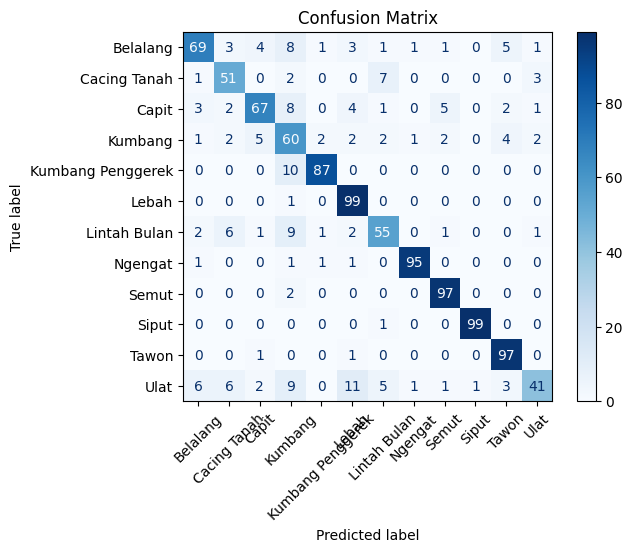

                   precision    recall  f1-score   support

         Belalang       0.83      0.71      0.77        97
     Cacing Tanah       0.73      0.80      0.76        64
            Capit       0.84      0.72      0.77        93
          Kumbang       0.55      0.72      0.62        83
Kumbang Penggerek       0.95      0.90      0.92        97
            Lebah       0.80      0.99      0.89       100
     Lintah Bulan       0.76      0.71      0.73        78
          Ngengat       0.97      0.96      0.96        99
            Semut       0.91      0.98      0.94        99
            Siput       0.99      0.99      0.99       100
            Tawon       0.87      0.98      0.92        99
             Ulat       0.84      0.48      0.61        86

         accuracy                           0.84      1095
        macro avg       0.84      0.83      0.82      1095
     weighted avg       0.85      0.84      0.83      1095



In [26]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## **b. Xception**

We also experimented with the Xception model as an alternative to MobileNetV2. Xception is a deeper architecture that uses depthwise separable convolutions and is known for its strong performance on image classification tasks.

The model was fine-tuned on the pests dataset, following the same training strategy:
- The top layers were customized with a GlobalAveragePooling2D layer, followed by a Dense layer with ReLU activation, dropout, and a softmax output layer.
- The model was compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.
- Early stopping and model checkpoint callbacks were applied to monitor validation accuracy and prevent overfitting.

After training, the model achieved **87% validation accuracy**. The evaluation results show strong performance across most classes, with precision and recall scores above 80% for nearly all categories.

The confusion matrix and classification report confirm that Xception performs slightly better than MobileNetV2 on this dataset.

In [27]:
base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [29]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [30]:
checkpoint = ModelCheckpoint(
    "xception_pests.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [31]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)


Epoch 1 dimulai...
Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.4930 - loss: 2.4743 Epoch 1 selesai dalam 102.46 detik
  → Training Accuracy: 66.83%
  → Validation Accuracy: 82.92% (-)
138/138 ━━━━━━━━━━━━━━━━━━━━ 102s 587ms/step - accuracy: 0.4943 - loss: 2.4704 - val_accuracy: 0.8292 - val_loss: 1.2796

Epoch 2 dimulai...
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8524 - loss: 1.2707 Epoch 2 selesai dalam 66.45 detik
  → Training Accuracy: 85.09%
  → Validation Accuracy: 86.67% (🔺 3.74%)
138/138 ━━━━━━━━━━━━━━━━━━━━ 66s 481ms/step - accuracy: 0.8524 - loss: 1.2707 - val_accuracy: 0.8667 - val_loss: 1.1609

Epoch 3 dimulai...
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8920 - loss: 1.1089 Epoch 3 selesai dalam 68.38 detik
  → Training Accuracy: 88.75%
  → Validation Accuracy: 87.76% (🔺 1.10%)
138/138 ━━━━━━━━━━━━━━━━━━━━ 68s 495ms/step - accuracy: 0.8919 - loss: 1.1090 - val_accuracy: 0.8776 - val_loss: 1.1292

E

In [32]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

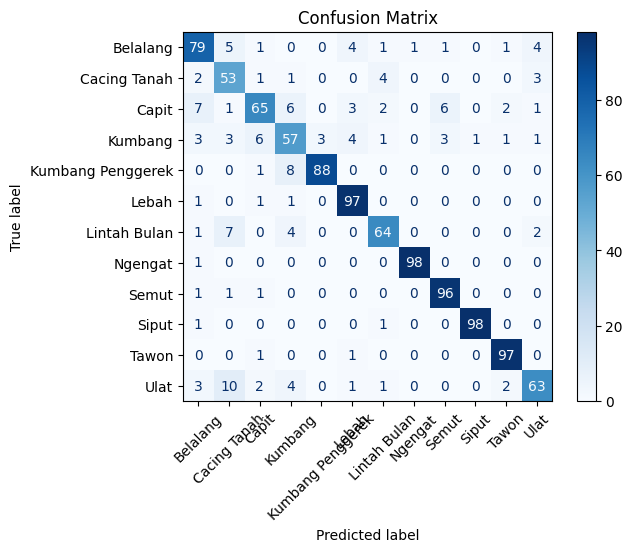

                   precision    recall  f1-score   support

         Belalang       0.80      0.81      0.81        97
     Cacing Tanah       0.66      0.83      0.74        64
            Capit       0.82      0.70      0.76        93
          Kumbang       0.70      0.69      0.70        83
Kumbang Penggerek       0.97      0.91      0.94        97
            Lebah       0.88      0.97      0.92       100
     Lintah Bulan       0.86      0.82      0.84        78
          Ngengat       0.99      0.99      0.99        99
            Semut       0.91      0.97      0.94        99
            Siput       0.99      0.98      0.98       100
            Tawon       0.94      0.98      0.96        99
             Ulat       0.85      0.73      0.79        86

         accuracy                           0.87      1095
        macro avg       0.86      0.86      0.86      1095
     weighted avg       0.87      0.87      0.87      1095



In [33]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# **6. Inference**

After training and saving the best model (e.g., `xception_pests.keras`), we perform inference on a new unseen image to predict the type of pests.

The steps include:
- Loading the trained model using `load_model()`.
- Loading a test image from the dataset using `image.load_img()`, resizing it to 224×224 pixels.
- Preprocessing the image: converting it to an array, normalizing pixel values, and expanding dimensions to match the model input shape.
- Using `model.predict()` to get the probability distribution over the 12 classes.
- Sorting and displaying the **top-3 most probable predictions** with their confidence scores.

This step demonstrates how the model can be used in real-world scenarios to identify pests based on image input.

In [35]:
model = load_model("xception_pests.keras")

img_path = "/content/drive/MyDrive/Capstone/Hama/Belalang/grasshopper (104).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

class_names = list(train_data.class_indices.keys())

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Top-3 Prediksi Hama:
- Belalang: 99%
- Kumbang: 0%
- Ulat: 0%


In [36]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Cacing Tanah/earthworms (100).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Cacing Tanah: 100%
- Lintah Bulan: 0%
- Ulat: 0%


In [38]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Capit/earwig (108).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Top-3 Prediksi Hama:
- Capit: 99%
- Semut: 1%
- Tawon: 0%


In [39]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Kumbang/beetle (106).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Top-3 Prediksi Hama:
- Kumbang: 63%
- Capit: 35%
- Cacing Tanah: 1%


In [40]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Kumbang Penggerek/Weevil (106).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Kumbang Penggerek: 100%
- Kumbang: 0%
- Tawon: 0%


In [41]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Lebah/bees (106).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Lebah: 99%
- Ngengat: 0%
- Tawon: 0%


In [42]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Lintah Bulan/slug (105).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Lintah Bulan: 69%
- Cacing Tanah: 14%
- Kumbang: 8%


In [43]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Ngengat/moth (102).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Ngengat: 100%
- Ulat: 0%
- Belalang: 0%


In [44]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Semut/ants (103).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Top-3 Prediksi Hama:
- Semut: 100%
- Capit: 0%
- Tawon: 0%


In [45]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Siput/snail (104).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Siput: 100%
- Lintah Bulan: 0%
- Belalang: 0%


In [47]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Tawon/wasp (506).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Top-3 Prediksi Hama:
- Tawon: 100%
- Capit: 0%
- Ulat: 0%


In [48]:
img_path = "/content/drive/MyDrive/Capstone/Hama/Ulat/catterpillar (105).jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Hama:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Top-3 Prediksi Hama:
- Ulat: 99%
- Capit: 1%
- Belalang: 0%
